In [1]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


2025-04-13 14:45:56.419903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744551956.433465 1383327 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744551956.437036 1383327 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-13 14:45:56.452529: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def map_int_to_direction(input):
    if input == 0:
        return maze_library.Direction.North
    if input == 1:
        return maze_library.Direction.East
    if input == 2:
        return maze_library.Direction.South
    else:
        return maze_library.Direction.West

In [3]:
env = maze_library.init_environment_python(10,10,5)
maze_library.create_kruzkals_maze(env)
maze_library.make_maze_imperfect(env)

In [4]:
def action_result_to_tuple(action_result):
    """
    Converts an ActionResult object into a tuple.

    Args:
        action_result (ActionResult): The result of an action in the environment.

    Returns:
        tuple: (observation, reward, done, truncated, info)
    """
    observation = action_result.observation  # The new observation after taking action
    reward = action_result.reward  # Reward received
    done = action_result.is_done  # Whether the episode is finished
    truncated = action_result.is_truncated  # Whether the episode was truncated
    info = action_result.info # Additional info

    return observation, reward, done, truncated, info


In [5]:
def action_result_to_input_vector(state, info):
    available_paths = state.available_paths
    visited_paths = state.visited_paths
    return np.array([
        available_paths.get(maze_library.Direction.North, 0),
        visited_paths.get(maze_library.Direction.North, False),
        available_paths.get(maze_library.Direction.East, 0),
        visited_paths.get(maze_library.Direction.East, False),
        available_paths.get(maze_library.Direction.South, 0),
        visited_paths.get(maze_library.Direction.South, False),
        available_paths.get(maze_library.Direction.West, 0),
        visited_paths.get(maze_library.Direction.West, False),
        info.previous_direction,
        state.current_location[0] ,
        state.current_location[1] ,
        state.end_node[0] ,
        state.end_node[1] ,
        info.previous_node[0] ,
        info.previous_node[1] ,
        info.manhattan_distance ,
        info.goal_dx,
        info.goal_dy,
        info.visited_amount 

    ])

In [6]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [19]  # == env.observation_space.shape
n_outputs = 4  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])



/home/art/Development/FYP/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744551957.806643 1383327 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1


In [7]:
print("Initial Q-values:", model.predict(np.random.rand(1, 19)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Initial Q-values: [[ 0.19519268  0.40761334 -0.11505733 -0.05951513]]


I0000 00:00:1744551958.620458 1383400 service.cc:148] XLA service 0x7f791c004f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744551958.620495 1383400 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
I0000 00:00:1744551958.628421 1383400 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744551958.725859 1383400 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
def epsilon_greedy_policy(flat_state, epsilon):
    if np.random.rand() < epsilon:
        # Choose only from valid actions
        return np.random.choice(n_outputs)
    else:
        Q_values = model.predict(flat_state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()


In [9]:
from collections import deque

replay_buffer = deque(maxlen=8000)

In [10]:
def sample_experiences(batch_size):
    sorted_experiences = sorted(replay_buffer, key=lambda exp: abs(exp[2]), reverse=True)
    half_batch = batch_size // 2

    # Ensure there are enough samples to choose from
    num_experiences = len(sorted_experiences)
    if num_experiences < batch_size:
        batch = sorted_experiences
    else:
        high_priority_samples = sorted_experiences[:half_batch]
        random_samples = [sorted_experiences[i] for i in np.random.choice(num_experiences, half_batch, replace=False)]
        batch = high_priority_samples + random_samples
    
    return [
        np.array([experience[field_index] for experience in batch], dtype=np.float32)
        for field_index in range(6)
    ]



In [11]:
reward_log = []
def play_one_step(env, state, info, epsilon):
    flat_state = action_result_to_input_vector(state, info)
    action = epsilon_greedy_policy(flat_state, epsilon)
    action_obj = maze_library.create_action(map_int_to_direction(action), 0)
    next_state, reward, done, truncated, new_info = action_result_to_tuple(env.take_action(action_obj))
    flat_next_state = action_result_to_input_vector(next_state, new_info)
    reward_log.append(reward)
    replay_buffer.append((flat_state, action, reward, flat_next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [12]:
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
highest_reward = -1000000

In [13]:
batch_size = 64
discount_factor = 0.96
q_value_log = []
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
loss_fn = tf.keras.losses.Huber(delta=1.0) # Use the class
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        q_value_log.extend(Q_values.numpy().flatten())
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [14]:
# Visualization function
def plot_q_values():
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


Episode: 0, Steps: 7, eps: 1.000, reward = -18.500000059604645
Episode: 86, Steps: 14, eps: 0.968, reward = 47.749998569488525
Episode: 100, Steps: 13, eps: 0.963, reward = -18.75
Episode: 103, Steps: 7, eps: 0.962, reward = 53.749998569488525
Episode: 139, Steps: 11, eps: 0.949, reward = 47.749998688697815
Episode: 200, Steps: 9, eps: 0.926, reward = -18.949999809265137
Episode: 269, Steps: 32, eps: 0.900, reward = 31.599998623132706
Episode: 285, Steps: 8, eps: 0.894, reward = 51.39999866485596
Episode: 300, Steps: 15, eps: 0.889, reward = -18.64999994635582
Episode: 400, Steps: 9, eps: 0.852, reward = -17.0
Episode: 443, Steps: 9, eps: 0.836, reward = 48.04999861121178
Episode: 454, Steps: 14, eps: 0.832, reward = 45.99999865889549
Episode: 478, Steps: 22, eps: 0.823, reward = 40.19999831914902


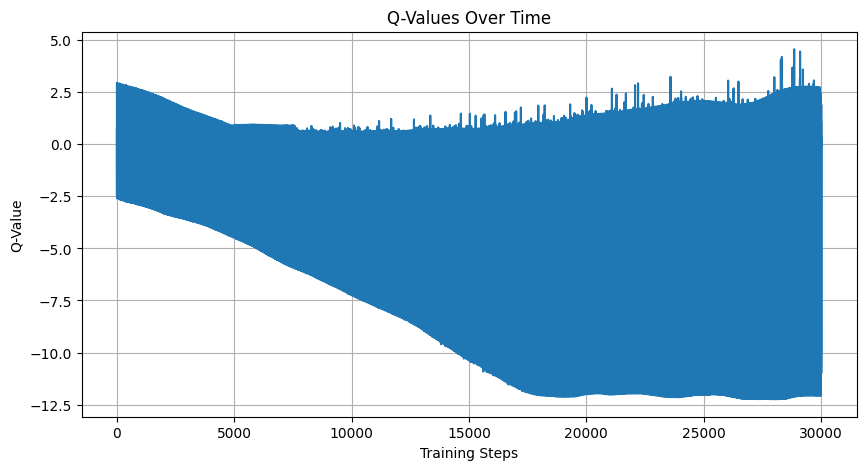

Episode: 500, Steps: 18, eps: 0.815, reward = -20.049999922513962
Episode: 513, Steps: 9, eps: 0.810, reward = 49.59999853372574
Episode: 514, Steps: 18, eps: 0.810, reward = 39.74999865889549
Episode: 525, Steps: 14, eps: 0.806, reward = 41.19999849796295
Episode: 529, Steps: 6, eps: 0.804, reward = 52.69999861717224
Episode: 570, Steps: 7, eps: 0.789, reward = 50.89999866485596
Episode: 600, Steps: 18, eps: 0.778, reward = -24.20000010728836
Episode: 604, Steps: 13, eps: 0.776, reward = 45.499998688697815
Episode: 628, Steps: 7, eps: 0.767, reward = 50.89999866485596
Episode: 633, Steps: 12, eps: 0.766, reward = 45.09999871253967
Episode: 635, Steps: 8, eps: 0.765, reward = 51.14999866485596
Episode: 664, Steps: 6, eps: 0.754, reward = 52.2999986410141
Episode: 684, Steps: 12, eps: 0.747, reward = 46.89999854564667
Episode: 700, Steps: 8, eps: 0.741, reward = -22.549999833106995
Episode: 724, Steps: 8, eps: 0.732, reward = 50.79999852180481
Episode: 729, Steps: 9, eps: 0.730, reward 

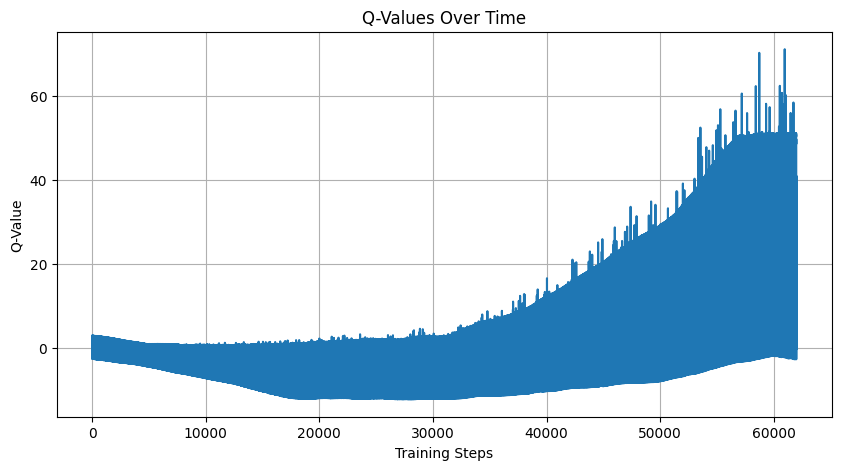

Episode: 1000, Steps: 12, eps: 0.630, reward = -15.84999993443489
Episode: 1001, Steps: 7, eps: 0.629, reward = 50.39999866485596
Episode: 1002, Steps: 11, eps: 0.629, reward = 44.04999840259552
Episode: 1005, Steps: 8, eps: 0.628, reward = 53.499998688697815
Episode: 1025, Steps: 7, eps: 0.620, reward = 50.89999866485596
Episode: 1029, Steps: 8, eps: 0.619, reward = 50.54999852180481
Episode: 1032, Steps: 12, eps: 0.618, reward = 45.69999873638153
Episode: 1051, Steps: 23, eps: 0.611, reward = 39.899998396635056
Episode: 1077, Steps: 6, eps: 0.601, reward = 52.2999986410141
Episode: 1081, Steps: 10, eps: 0.600, reward = 48.04999852180481
Episode: 1100, Steps: 7, eps: 0.593, reward = 52.19999849796295
Episode: 1102, Steps: 10, eps: 0.592, reward = 48.49999850988388
Episode: 1111, Steps: 9, eps: 0.589, reward = 49.84999853372574
Episode: 1123, Steps: 12, eps: 0.584, reward = 50.44999861717224
Episode: 1138, Steps: 14, eps: 0.579, reward = 42.84999841451645
Episode: 1140, Steps: 7, eps: 

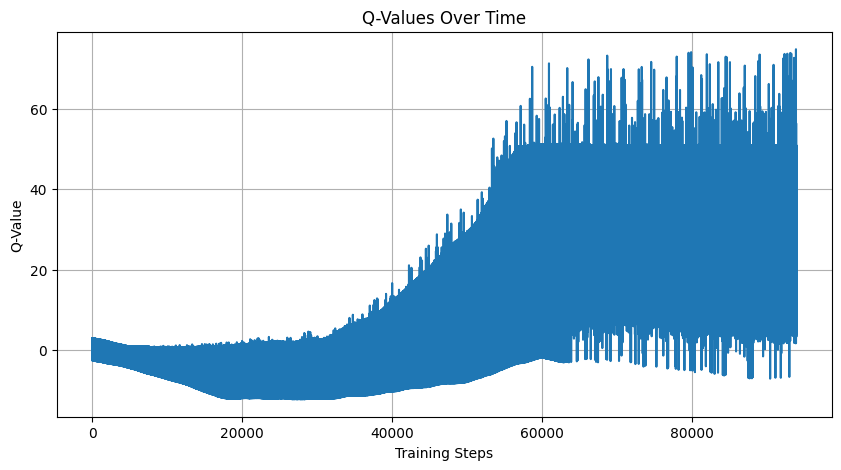

Episode: 1500, Steps: 11, eps: 0.444, reward = -14.74999988079071
Episode: 1502, Steps: 8, eps: 0.444, reward = 50.749998569488525
Episode: 1507, Steps: 6, eps: 0.442, reward = 52.7999986410141
Episode: 1510, Steps: 11, eps: 0.441, reward = 49.649998635053635
Episode: 1513, Steps: 10, eps: 0.440, reward = 48.19999849796295
Episode: 1515, Steps: 11, eps: 0.439, reward = 45.09999859333038
Episode: 1519, Steps: 8, eps: 0.437, reward = 48.69999849796295
Episode: 1520, Steps: 8, eps: 0.437, reward = 48.44999849796295
Episode: 1530, Steps: 11, eps: 0.433, reward = 44.149998396635056
Episode: 1535, Steps: 7, eps: 0.431, reward = 52.2499985396862
Episode: 1536, Steps: 7, eps: 0.431, reward = 52.19999849796295
Episode: 1541, Steps: 5, eps: 0.429, reward = 54.09999859333038
Episode: 1544, Steps: 12, eps: 0.428, reward = 50.39999854564667
Episode: 1570, Steps: 10, eps: 0.419, reward = 46.999998450279236
Episode: 1577, Steps: 9, eps: 0.416, reward = 46.249998450279236
Episode: 1578, Steps: 7, eps:

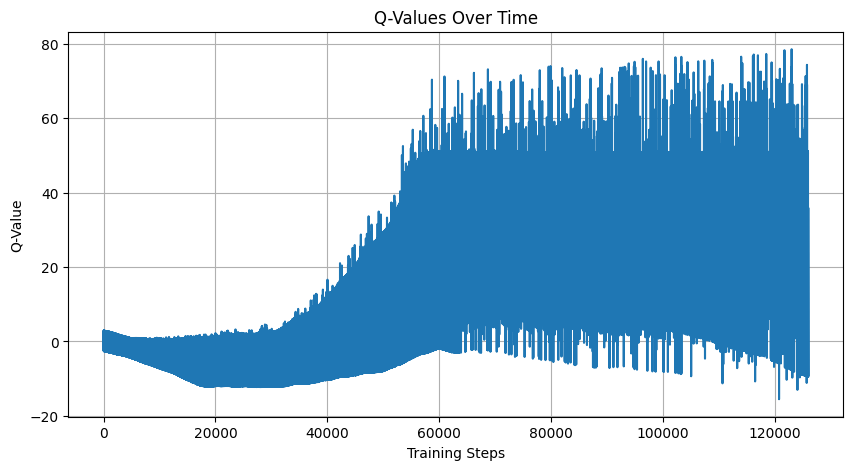

Episode: 2000, Steps: 7, eps: 0.259, reward = -17.74999988079071
Episode: 2025, Steps: 7, eps: 0.250, reward = 55.5499986410141
Episode: 2050, Steps: 8, eps: 0.241, reward = 51.24999862909317
Episode: 2056, Steps: 7, eps: 0.239, reward = 51.249998688697815
Episode: 2058, Steps: 5, eps: 0.238, reward = 54.34999859333038
Episode: 2061, Steps: 10, eps: 0.237, reward = 49.89999854564667
Episode: 2086, Steps: 5, eps: 0.227, reward = 54.34999859333038
Episode: 2094, Steps: 5, eps: 0.224, reward = 53.84999859333038
Episode: 2100, Steps: 7, eps: 0.222, reward = -17.74999988079071
Episode: 2143, Steps: 5, eps: 0.206, reward = 54.34999859333038
Episode: 2158, Steps: 7, eps: 0.201, reward = 52.44999849796295
Episode: 2181, Steps: 5, eps: 0.192, reward = 54.34999859333038
Episode: 2200, Steps: 7, eps: 0.185, reward = -14.399999737739563
Episode: 2204, Steps: 8, eps: 0.184, reward = 52.44999861717224
Episode: 2218, Steps: 10, eps: 0.179, reward = 49.89999854564667
Episode: 2219, Steps: 5, eps: 0.17

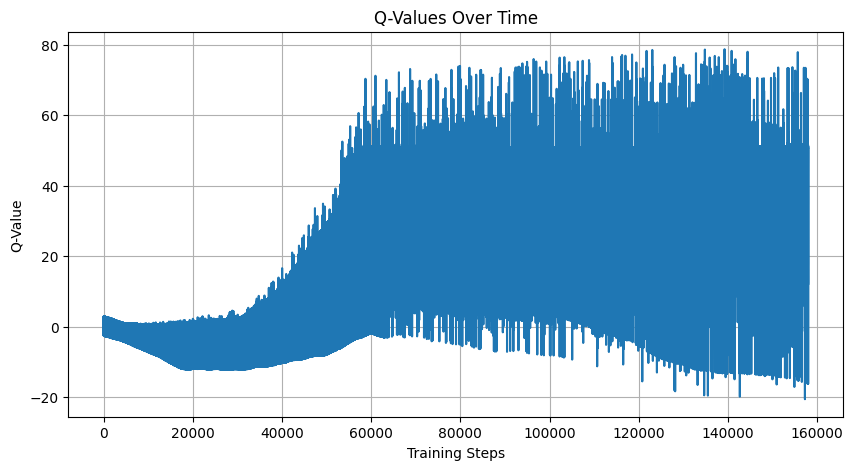

Episode: 2500, Steps: 7, eps: 0.074, reward = -17.74999988079071
Episode: 2600, Steps: 7, eps: 0.037, reward = -17.99999988079071


KeyboardInterrupt: 

In [15]:
steps = 3000

# In the plotting function:
for episode in range(steps):
    result = env.reset()   
    obs, reward, done, truncated, info = action_result_to_tuple(result)
    cumilative_reward = 0
    for step in range(steps):
        epsilon = max(1 - episode / (steps * 0.9), 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, info, epsilon)
        cumilative_reward += reward
        if done or truncated:
            break

    # Extra debug information
    if episode% 100 == 0 or cumilative_reward > 0:
        print(f"\rEpisode: {episode}, Steps: {step}, eps: {epsilon:.3f}, reward = {cumilative_reward}")
    rewards.append(cumilative_reward)
    
    if cumilative_reward > highest_reward:
        best_weights = model.get_weights()
        highest_reward = cumilative_reward

    if episode > 30:
        training_step(batch_size)
    if episode % 500 == 499:
        plot_q_values()
        
    with open(f'../mazeLogs/solve{episode}.json', 'w') as file:
        file.write(env.to_json_python())

    

model.set_weights(best_weights)  # extra code – restores the best model weights

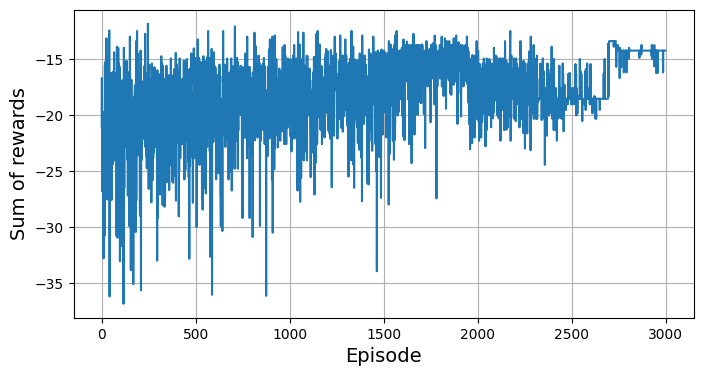

In [ ]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

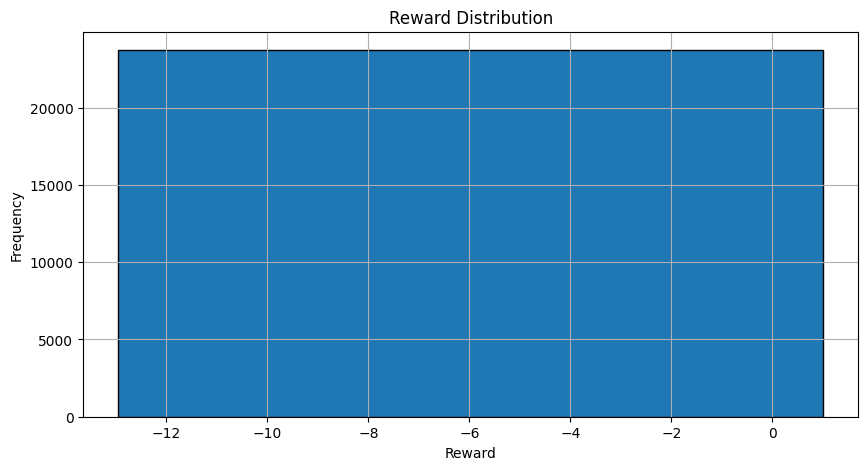

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(reward_log, bins=1, edgecolor='black')
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()